# Introduction

We have data on a set of disruptions in which the B6 was mentioned as a potential rerouting. The B6 bus was the route that most frequently appeared in about a month's worth of service alerts related to subway disruptions. In this file, we will train a model that uses a **disruption** feature based on these disruptions. Our goal is to see whether adding this feature provides any improvement to the performance of our model. We will try two different versions of the disruption feature: one which is a binary variable indication whether a disruption is active, as well as an ordinal variabel indicating the severity of the disruption, as reported by the MTA. 

# Preparing data
## Imports

In [1]:
import pandas as pd
import passenger_pred.load as ppl
import passenger_pred.preprocess as ppp
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

## Loading B6 data

The earliest date for which we have a recorded alert is Wednesday, October 27th. The last alert we have included is from November 22nd. We will thus load B6 data from October 28th until November 21st. 

In [123]:
B6_DIR = "../data/B6/"

df_b6 = pd.read_csv(B6_DIR + "B6_20211028_20211121.csv")
df_b6.shape

(909698, 24)

## Preprocessing data

In [124]:
df_b6 = ppp.add_uid(df_b6)
df_b6 = ppp.remove_duplicate_stops(df_b6)
df_b6 = ppp.add_time_features(df_b6)
df_b6 = ppp.fill_zero_passengers(df_b6)
df_b6 = ppp.add_cycl_features(df_b6)

In [125]:
df_b6.columns

Index(['Unnamed: 0', 'route', 'timestamp', 'route_long', 'direction',
       'service_date', 'trip_id', 'gtfs_shape_id', 'route_short', 'agency',
       'origin_id', 'destination_name', 'next_stop_id', 'next_stop_eta',
       'next_stop_d_along_route', 'next_stop_d', 'lat', 'lon', 'bearing',
       'progress_rate', 'vehicle_id', 'gtfs_block_id', 'passenger_count',
       'progress_status', 'uid', 'timestamp_dt', 'hour', 'day', 'dow',
       'cos_hour', 'cos_day', 'cos_dow'],
      dtype='object')

In [126]:
df_b6 = df_b6[df_b6.passenger_count.notna()]
df_b6 = df_b6[df_b6.passenger_count != "None"]
df_b6.shape

(374237, 32)

In [127]:
df_b6['next_stop'] = pd.Categorical(df_b6.next_stop_id, ordered=False)
df_b6['next_stop'] = df_b6['next_stop'].cat.codes
df_b6.shape

(374237, 33)

## Add disruption information
We need to load information related to the disruptions, if we would like to include this information in the B6 dataset. 

In [128]:
alert_df = pd.read_csv("../data/unplanned_alerts/B6_20211028_20211121_time.csv")
alert_df.shape

(16, 12)

In [129]:
B6_alert = alert_df.copy()
B6_alert.head()

,Unnamed: 0,startDate,direction,endDate,statusSummary,id,priority,line,creationDate,statusDescription,end_time,alert_minutes
0,0,2021-11-13 23:50:54+00:00,0,2021-11-14 01:30:02+00:00,Trains Rerouted,lmm:alert:107703,32,N,2021-11-13T17:42:07-0500,<p>Northbound [D][N][R] trains are not running...,1636852802,99.133333
1,1,2021-11-22 22:00:00+00:00,1,2021-11-22 23:00:02+00:00,Delays,lmm:alert:109892,22,W,2021-11-22T15:18:29-0500,<p>[N] [Q] [R] [W] trains are <strong>rerouted...,1637621402,60.033333
2,2,2021-11-13 23:00:42+00:00,0,2021-11-13 23:20:01+00:00,Some Reroutes,lmm:alert:107686,25,N,2021-11-13T17:42:07-0500,<p>[D] [N] [R] trains are not running between ...,1636845001,19.316667
3,3,2021-10-28 07:07:48+00:00,0,2021-10-28 09:00:02+00:00,Local to Express,lmm:alert:103819,27,F,2021-10-28T03:07:48-0400,<p>Southbound [F] [G] trains are rerouted whil...,1635407402,112.233333
4,4,2021-11-14 07:47:15+00:00,1,2021-11-14 09:40:02+00:00,Part Suspended,lmm:alert:107759,35,G,2021-11-14T02:26:12-0500,<p>[G] service is suspended in both directions...,1636882202,112.783333


We now need to add the information from the alert `df` to the B6 `df`, if there was an alert active at the time that a record was recorded. 

In [130]:
B6_alert['startDate'] = pd.to_datetime(B6_alert.startDate, utc=True)
B6_alert['endDate'] = pd.to_datetime(B6_alert.endDate, utc=True)

df_b6['timestamp'] = pd.to_datetime(df_b6.timestamp, utc=True)

In [131]:
def alert_active(row, alert_df, boolean=True, time_column='timestamp'):
    valid_rows = alert_df[
        (alert_df.startDate < row[time_column]) &
        (row[time_column] < alert_df.endDate) 
    ]
    if boolean:
        return min(valid_rows.shape[0], 1)
    elif valid_rows.shape[0] > 0:
        return valid_rows.priority.max()
    else:
        return 0

In [132]:
df_b6['alert_ind'] = df_b6.apply(lambda x: alert_active(x, B6_alert), axis=1)
df_b6['alert_prio'] = df_b6.apply(lambda x: alert_active(x, B6_alert, boolean=False), axis=1)

In [133]:
df_b6.passenger_count = df_b6.passenger_count.astype(int)

In [134]:
df_b6.to_pickle("B6_20211028_20211122_alerts.pkl")

In [135]:
df_b6 = pd.read_pickle("B6_20211028_20211122_alerts.pkl")

In [136]:
df_b6[df_b6['alert_prio'] > 0].alert_prio.describe()

count    4062.000000
mean       31.682422
std         3.192900
min        25.000000
25%        27.000000
50%        32.000000
75%        35.000000
max        35.000000
Name: alert_prio, dtype: float64

# Data analysis
A question we might first like to answer is: are average `passenger_count` values higher when an alert is active?

In [137]:
round(df_b6[df_b6.alert_ind == 1].passenger_count.mean(), 2)

13.66

In [138]:
round(df_b6[df_b6.alert_ind == 0].passenger_count.mean(), 2)

12.47

A very naive method of answering this question appears to suggest that passenger levels are indeed higher when an alert is active, although not by much. Now, it must be noted that it may be true that all these alerts were active during times of date that are always busy. Therefore, it would be better to compare the number of passengers during a time period when an alert was active, compare to a similar time of day during another day. We will do this for each of the sixteen alerts that we have included in our dataset. 

In [139]:
relevant_B6_data = df_b6[df_b6.alert_ind == 1]
non_alert_B6_data = df_b6[df_b6.alert_ind == 0]

(relevant_B6_data.shape, non_alert_B6_data.shape)

((4062, 35), (370175, 35))

In [140]:
means_alert = []
means_normal = []

for i in B6_alert.index:
    row = B6_alert.loc[i]
    # print(row[['startDate', 'endDate']])
    # print("dow", row.startDate.dayofweek)
    records = relevant_B6_data[
        (relevant_B6_data.timestamp > row.startDate) &
        (relevant_B6_data.timestamp < row.endDate)
    ]
    if records.shape[0] < 5:
        continue
    mean_alert = records.passenger_count.mean()

    # find similar records
    dow = records.dow.min()
    dow_df = non_alert_B6_data[non_alert_B6_data.dow == dow]
    dow_time_df = dow_df[
        (dow_df.hour >= row.startDate.hour) &
        (dow_df.hour <= row.endDate.hour)
    ]
    print(dow_time_df.shape)
    mean_normal = dow_time_df.passenger_count.mean()
    if mean_normal is not np.nan:
        means_alert.append(mean_alert)
        means_normal.append(mean_normal)

(0, 35)
(2166, 35)
(1943, 35)
(958, 35)
(4263, 35)
(419, 35)
(2231, 35)
(2545, 35)
(2223, 35)
(0, 35)
(4756, 35)


In [141]:
deviation = [alert - normal for alert, normal in zip(means_alert, means_normal)]
deviation

[-0.5929541899862443,
 -0.8612776379788389,
 -0.4261301716101418,
 1.5801774094056533,
 1.4015899452275882,
 -1.9916652751045163,
 0.7009033379076133,
 4.53366222484382,
 -0.2640675385345119]

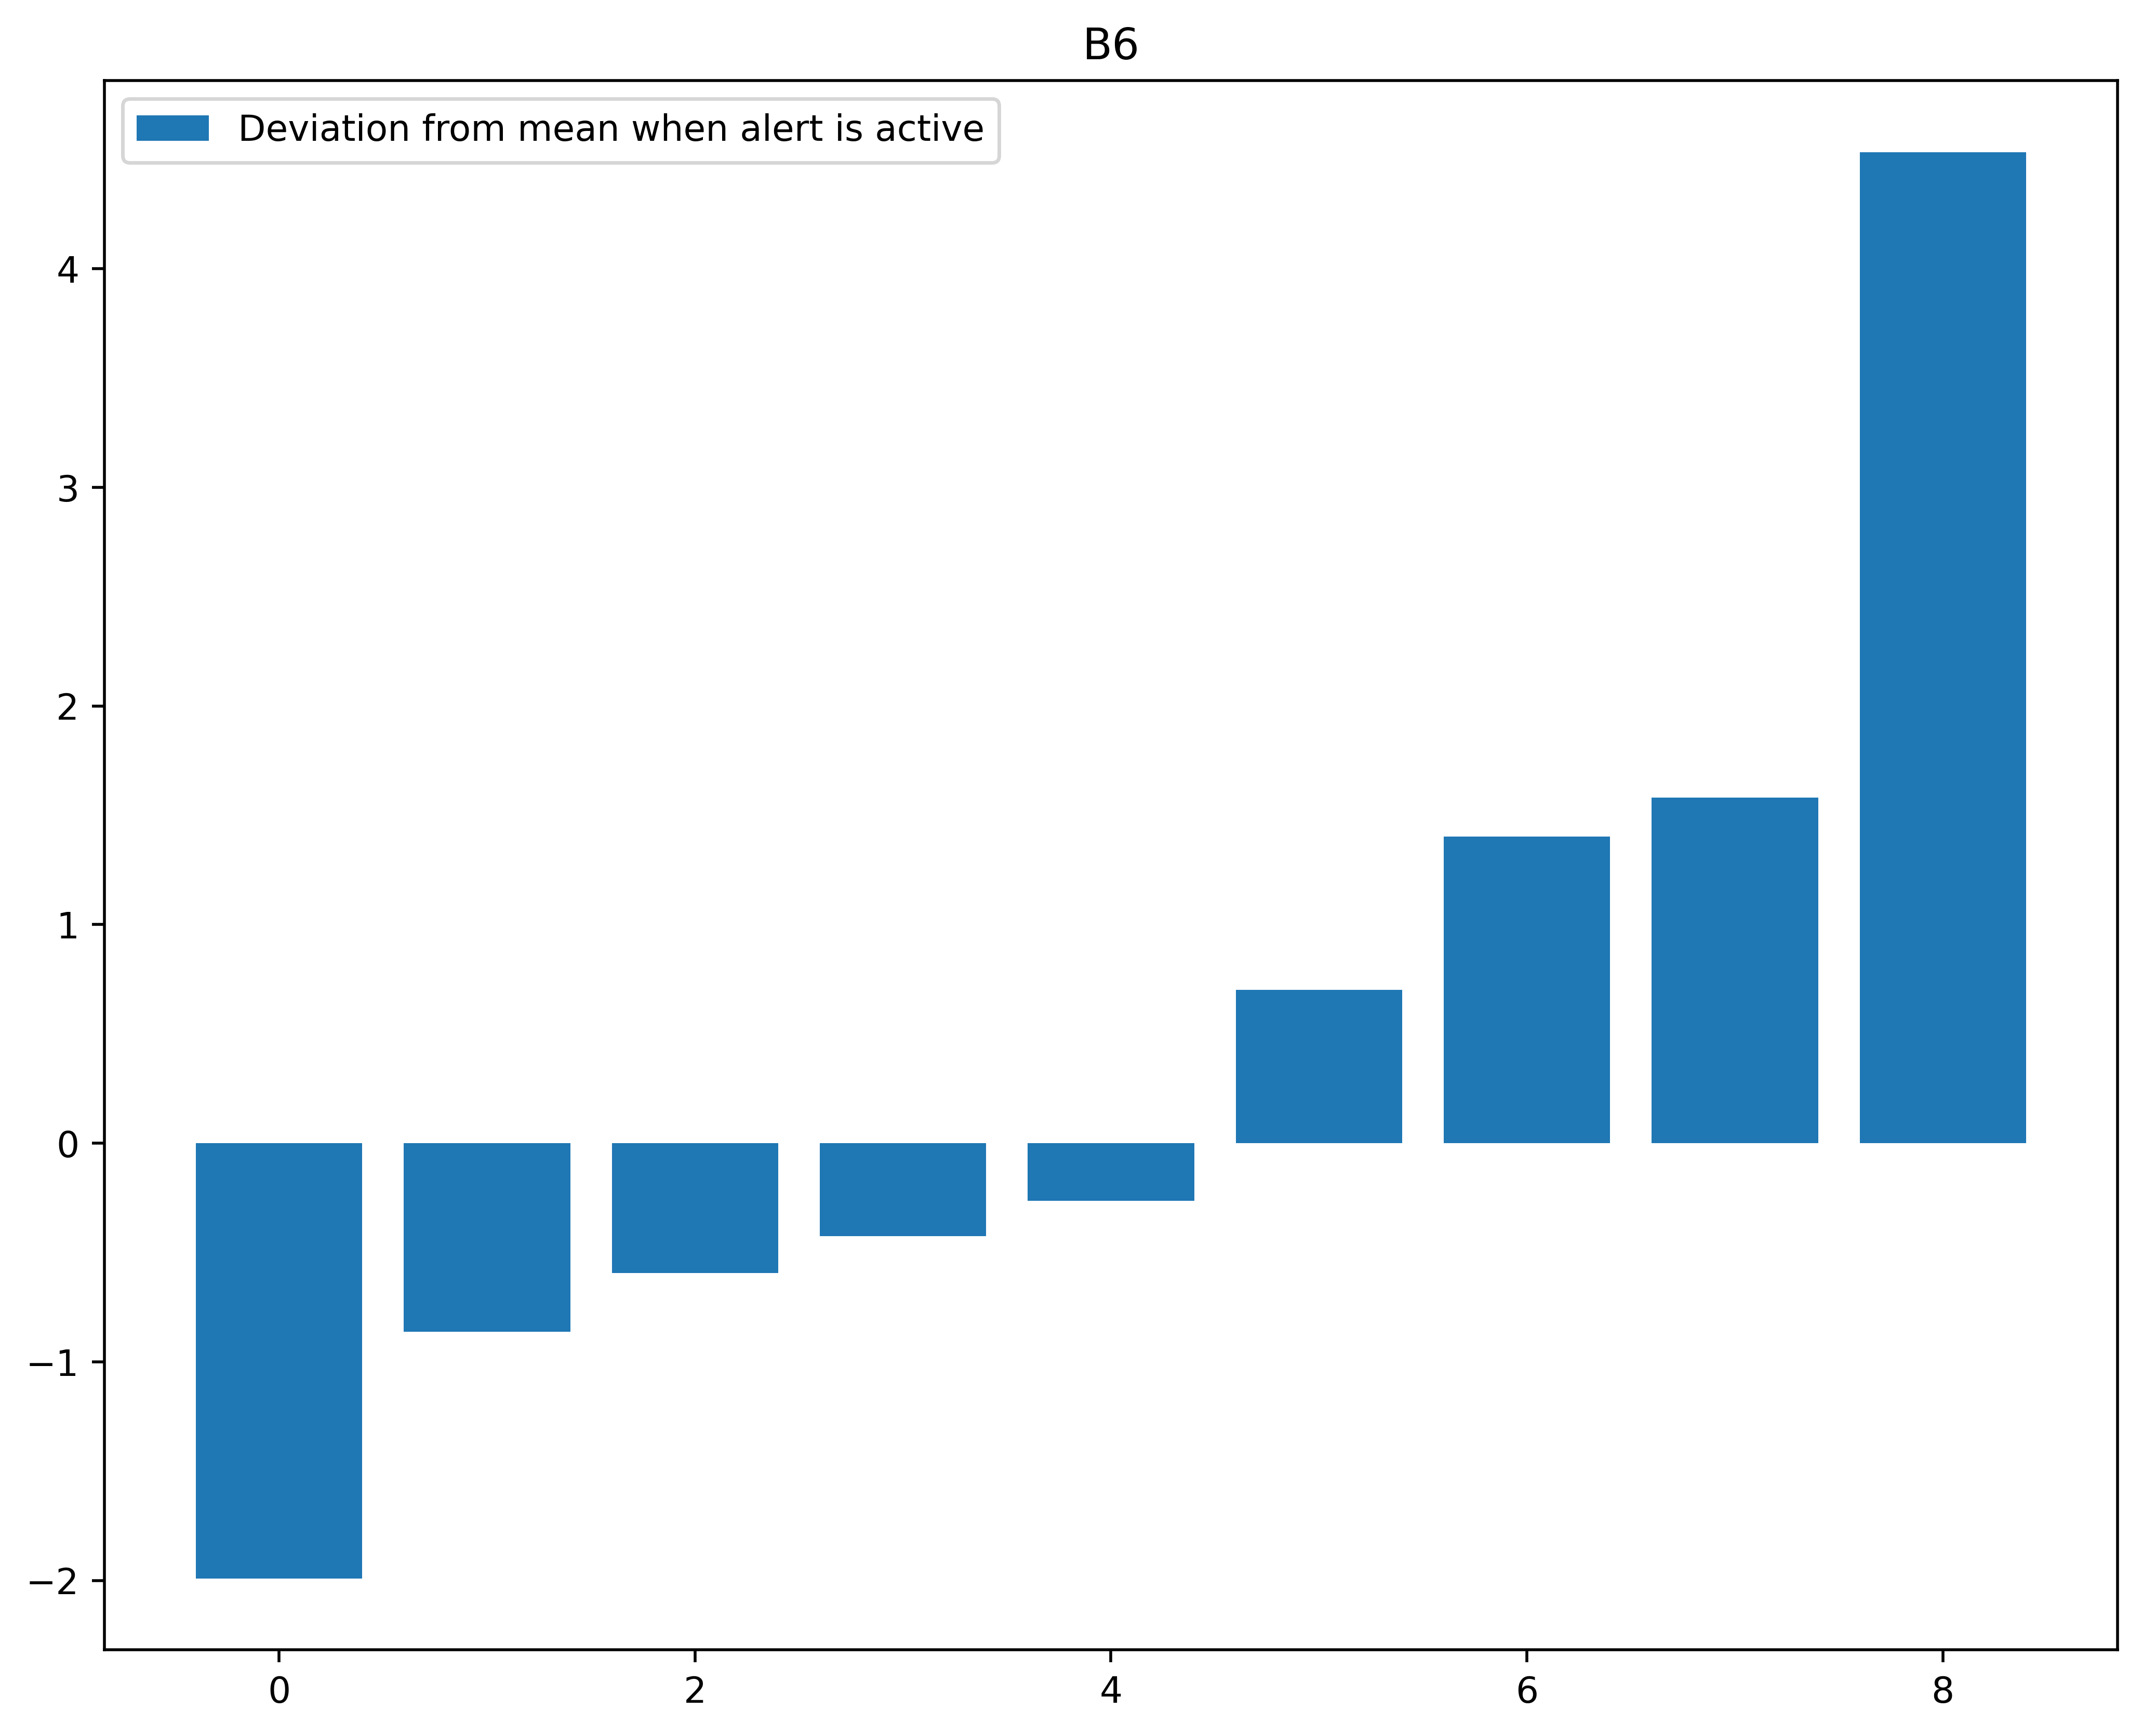

In [193]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=500)

ax.bar([i for i in range(9)], sorted(deviation), label = "Deviation from mean when alert is active",)
ax.set_title("B6")
ax.set_xlabel("Alert")
ax.set_ylabel("Number of passengers")
ax.legend()

# Training models
We want to train and compare three different models
- Base model (without alert information)
- Boolean alert model
- Priority alert model

We will split our data s.t. we predict on one week of data. 

In [143]:
df_test = df_b6[
    (df_b6.day > 15) &
    (df_b6.day < 23)
]

df_train = df_b6[~df_b6.index.isin(df_test.index)]

(df_train.shape, df_test.shape)

((272736, 35), (101501, 35))

## Feature enrichment

In [144]:
def add_averages(df_train, df_test, stop_column='next_stop'):
    mean_hour = df_train.groupby([stop_column, 'hour']).passenger_count.mean()
    mean_dow = df_train.groupby([stop_column, 'dow']).passenger_count.mean()
    mean_day = df_train.groupby([stop_column, 'day']).passenger_count.mean()
    
    df_train = df_train.join(mean_hour, on=[stop_column, 'hour'], rsuffix='_mean_hr')
    df_train = df_train.join(mean_dow, on=[stop_column, 'dow'], rsuffix='_mean_dow')
    df_train = df_train.join(mean_day, on=[stop_column, 'day'], rsuffix='_mean_day')

    df_test = df_test.join(mean_hour, on=[stop_column, 'hour'], rsuffix='_mean_hr')
    df_test = df_test.join(mean_dow, on=[stop_column, 'dow'], rsuffix='_mean_dow')
    df_test = df_test.join(mean_day, on=[stop_column, 'day'], rsuffix='_mean_day')
    return df_train, df_test

In [145]:
df_train, df_test = add_averages(df_train, df_test)

In [146]:
df_train.shape, df_test.shape

((272736, 38), (101501, 38))

## Base model

In [147]:
base_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
    "cos_hour",
    "cos_day",
    "cos_dow",
    # "passenger_count_mean_hr",
    # "passenger_count_mean_dow",
    # "passenger_count_mean_day",
    # "passenger_count"
]

X_train_base = df_train[base_train_columns]
y_train_base = df_train.passenger_count

X_test_base = df_test[base_train_columns]
y_test_base = df_test.passenger_count

X_train_base.shape, y_train_base.shape, X_test_base.shape, y_test_base.shape

((272736, 10), (272736,), (101501, 10), (101501,))

In [148]:
# regr_base = XGBRegressor(learning_rate=0.05, max_depth=5, objective='reg:linear', n_estimators=100, colsample_bytree=0)
regr_base = XGBRegressor(learning_rate=0.1, max_depth=5, objective='reg:linear', n_estimators=100,)

eval_set_base = [(X_train_base, y_train_base), (X_test_base, y_test_base)]

regr_base.fit(X=X_train_base, y=y_train_base, eval_metric=["rmsle", "mae"], eval_set=eval_set_base, verbose=True)

[18:06:28] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmsle:1.50361	validation_0-mae:10.85904	validation_1-rmsle:1.53470	validation_1-mae:11.24130
[1]	validation_0-rmsle:1.24063	validation_0-mae:10.00227	validation_1-rmsle:1.27086	validation_1-mae:10.38432
[2]	validation_0-rmsle:1.08079	validation_0-mae:9.32116	validation_1-rmsle:1.10792	validation_1-mae:9.69388
[3]	validation_0-rmsle:0.98036	validation_0-mae:8.78300	validation_1-rmsle:1.00216	validation_1-mae:9.13622
[4]	validation_0-rmsle:0.91409	validation_0-mae:8.36145	validation_1-rmsle:0.93089	validation_1-mae:8.69280
[5]	validation_0-rmsle:0.87134	validation_0-mae:8.04117	validation_1-rmsle:0.88318	validation_1-mae:8.34932
[6]	validation_0-rmsle:0.84401	validation_0-mae:7.79665	validation_1-rmsle:0.85089	validation_1-mae:8.07951
[7]	validation_0-rmsle:0.82633	validation_0-mae:7.60694	validation_1-rmsle:0.82898	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [149]:
y_pred_base = regr_base.predict(X_test_base)
mae_base = mean_absolute_error(y_test_base, y_pred_base)
round(mae_base, 3)

6.948

In [150]:
for title, val in zip(base_train_columns, regr_base.feature_importances_):
    print(title, round(val, 3))

direction 0.052
next_stop 0.064
lat 0.171
lon 0.164
hour 0.2
day 0.043
dow 0.101
cos_hour 0.076
cos_day 0.076
cos_dow 0.054


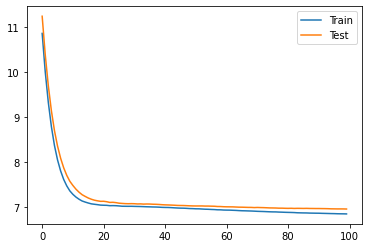

In [151]:
results = regr_base.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)


fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()

## Boolean alert model

In [153]:
bool_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
    "alert_ind",
    "cos_hour",
    "cos_day",
    "cos_dow"
    # "passenger_count_mean_hr",
    # "passenger_count_mean_dow",
    # "passenger_count_mean_day",
]

X_train_bool = df_train[bool_train_columns]
y_train_bool = df_train.passenger_count

X_test_bool = df_test[bool_train_columns]
y_test_bool = df_test.passenger_count

X_train_bool.shape, y_train_bool.shape, X_test_bool.shape, y_test_bool.shape

((272736, 11), (272736,), (101501, 11), (101501,))

In [155]:
# regr_bool = XGBRegressor(learning_rate=0.03, max_depth=6, objective='reg:gamma', n_estimators=400, gamma=4)
regr_bool = XGBRegressor(learning_rate=0.3, max_depth=6, objective='reg:linear', n_estimators=100)

eval_set_bool = [(X_train_bool, y_train_bool), (X_test_bool, y_test_bool)]

regr_bool.fit(X=X_train_bool, y=y_train_bool, eval_metric=["rmsle", "mae"], eval_set=eval_set_bool, verbose=True)

[18:06:54] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmsle:1.03794	validation_0-mae:9.08287	validation_1-rmsle:1.06513	validation_1-mae:9.45907
[1]	validation_0-rmsle:0.84493	validation_0-mae:7.80997	validation_1-rmsle:0.85241	validation_1-mae:8.09191
[2]	validation_0-rmsle:0.80109	validation_0-mae:7.28580	validation_1-rmsle:0.79541	validation_1-mae:7.48278
[3]	validation_0-rmsle:0.79604	validation_0-mae:7.07643	validation_1-rmsle:0.78293	validation_1-mae:7.21491
[4]	validation_0-rmsle:0.80147	validation_0-mae:7.00999	validation_1-rmsle:0.78432	validation_1-mae:7.10804
[5]	validation_0-rmsle:0.80683	validation_0-mae:6.96790	validation_1-rmsle:0.78937	validation_1-mae:7.04594
[6]	validation_0-rmsle:0.80963	validation_0-mae:6.93814	validation_1-rmsle:0.79343	validation_1-mae:7.02140
[7]	validation_0-rmsle:0.81340	validation_0-mae:6.92298	validation_1-rmsle:0.80055	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

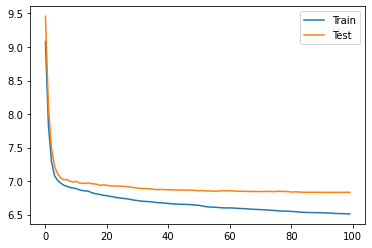

In [156]:
results = regr_bool.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)


fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()

In [157]:
y_pred_bool = regr_bool.predict(X_test_bool)
mae_bool = mean_absolute_error(y_test_bool, y_pred_bool)
round(mae_bool, 3)

6.833

In [158]:
for title, val in zip(bool_train_columns, regr_bool.feature_importances_):
    print(title, round(val, 3))

direction 0.065
next_stop 0.087
lat 0.128
lon 0.114
hour 0.202
day 0.034
dow 0.128
alert_ind 0.014
cos_hour 0.095
cos_day 0.062
cos_dow 0.072


## Priority alert model

In [160]:
prio_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
    "cos_hour",
    "cos_day",
    "cos_dow",
    "alert_prio", 
]

X_train_prio = df_train[prio_train_columns]
y_train_prio = df_train.passenger_count

X_test_prio = df_test[prio_train_columns]
y_test_prio = df_test.passenger_count

X_train_prio.shape, y_train_prio.shape, X_test_prio.shape, y_test_prio.shape

((272736, 11), (272736,), (101501, 11), (101501,))

In [161]:
regr_prio = XGBRegressor(learning_rate=0.1, max_depth=6, objective='reg:linear', n_estimators=500)

eval_set_prio = [(X_train_prio, y_train_prio), (X_test_prio, y_test_prio)]

regr_prio.fit(X=X_train_prio, y=y_train_prio, eval_metric=["rmsle", "mae"], eval_set=eval_set_prio, verbose=True)

[18:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmsle:1.50118	validation_0-mae:10.85419	validation_1-rmsle:1.53309	validation_1-mae:11.24086
[1]	validation_0-rmsle:1.23709	validation_0-mae:9.98661	validation_1-rmsle:1.26675	validation_1-mae:10.37030
[2]	validation_0-rmsle:1.07667	validation_0-mae:9.29431	validation_1-rmsle:1.10252	validation_1-mae:9.66517
[3]	validation_0-rmsle:0.97591	validation_0-mae:8.75164	validation_1-rmsle:0.99694	validation_1-mae:9.10524
[4]	validation_0-rmsle:0.90921	validation_0-mae:8.32680	validation_1-rmsle:0.92487	validation_1-mae:8.65385
[5]	validation_0-rmsle:0.86430	validation_0-mae:7.99141	validation_1-rmsle:0.87532	validation_1-mae:8.29378
[6]	validation_0-rmsle:0.83527	validation_0-mae:7.73308	validation_1-rmsle:0.84166	validation_1-mae:8.00993
[7]	validation_0-rmsle:0.81602	validation_0-mae:7.53081	validation_1-rmsle:0.81730	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [162]:
y_pred_prio = regr_prio.predict(X_test_prio)
mae_prio = mean_absolute_error(y_test_prio, y_pred_prio)
round(mae_prio, 3)

6.768

In [163]:
for title, val in zip(prio_train_columns, regr_prio.feature_importances_):
    print(title, round(val, 3))

direction 0.09
next_stop 0.105
lat 0.132
lon 0.116
hour 0.188
day 0.043
dow 0.129
cos_hour 0.064
cos_day 0.062
cos_dow 0.052
alert_prio 0.019


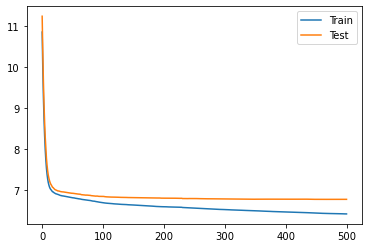

In [164]:
results = regr_prio.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()

# Result analysis

How much improvement do we find in terms of MAE?

In [165]:
round((1 - mae_bool / mae_base) * 100, 2)

1.65

In [166]:
round((1 - mae_prio / mae_base) * 100, 2)

2.59

So we find 0.24% improvement when using the boolean column, and 0.61% improvement when using the priority column. These values are not particularly high. We can try to improve on these. Let's first dive a little deeper into these results. 

In [167]:
alert_index = X_test_bool[X_test_bool.alert_ind == 1].index
len(alert_index)

398

In [331]:
X_test_bool

,direction,next_stop,lat,lon,hour,day,dow,alert_ind
374489,1,125,40.650328,-73.894332,0,16,1,0
374490,1,98,40.613789,-73.981462,0,16,1,0
374494,1,106,40.632499,-73.918642,0,16,1,0
374496,1,95,40.616830,-73.978283,0,16,1,0
374497,0,20,40.619278,-73.976383,0,16,1,0
...,...,...,...,...,...,...,...,...
501596,0,118,40.657750,-73.878915,4,22,0,0
501598,1,62,40.653146,-73.889566,4,22,0,0
501599,0,119,40.658488,-73.877714,4,22,0,0
501602,1,88,40.634244,-73.949158,4,22,0,0


In [335]:
X_test_full = X_test_bool.copy()
X_test_full['y_pred_base'] = y_pred_base
X_test_full['y_pred_bool'] = y_pred_bool
X_test_full['y_pred_prio'] = y_pred_prio
X_test_full['y_test'] = y_test_base

In [338]:
X_test_full['base_error'] = X_test_full.y_test - X_test_full.y_pred_base
X_test_full['bool_error'] = X_test_full.y_test - X_test_full.y_pred_bool
X_test_full['prio_error'] = X_test_full.y_test - X_test_full.y_pred_prio

In [414]:
error_cols = ['base_error', 'bool_error', 'prio_error']

np.abs(X_test_full[error_cols]).mean()

base_error    6.882858
bool_error    6.866127
prio_error    6.840961
dtype: float32

In [415]:
np.abs(X_test_full[X_test_full.alert_ind == 1][error_cols]).mean()

base_error    5.139672
bool_error    5.210606
prio_error    5.115318
dtype: float32

In the samples where an alert is active, there is some interesting behaviour. First, the error is actually higher than the base case when using the boolean indicator. When using the priority as a feature, the result is slightly better than the base case. This is somewhat unexpected: we would have expected the indication of an alert to help in predicting better values. Let's see what has happened to the errors in the rest of the dataset. 

In [356]:
np.abs(X_test_full[X_test_full.alert_ind == 0][error_cols]).mean()

base_error    6.889851
bool_error    6.872763
prio_error    6.847880
dtype: float32

These values follow a similar trend as the ones of the full dataset. This is to be expected: after all, the alert samples make up less than 2% of the data. 

In [379]:
X_test_full['prio_improvement'] = X_test_full.prio_error - X_test_full.base_error 

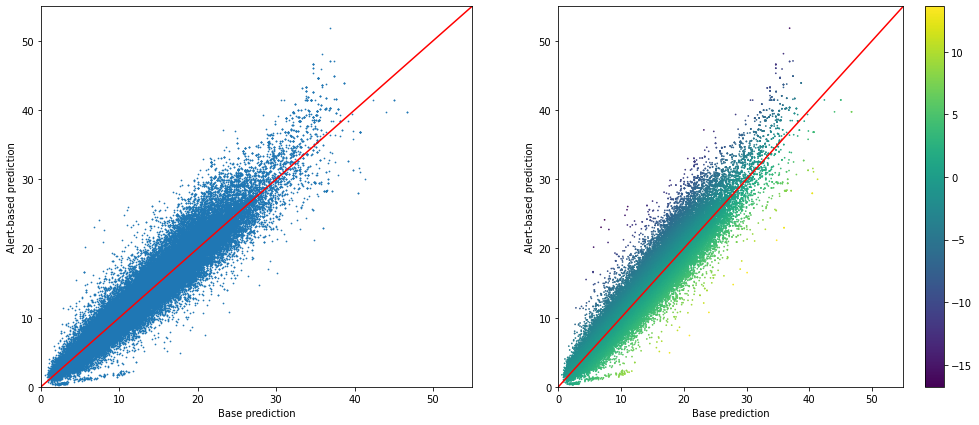

In [387]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].scatter(X_test_full.y_pred_base, X_test_full.y_pred_prio, s=0.5)
ax[0].set_xlabel("Base prediction")
ax[0].set_ylabel("Alert-based prediction")
ax[0].set_xlim(0, 55)
ax[0].set_ylim(0, 55)
ax[0].plot([0, 55], [0, 55], c='r')

im = ax[1].scatter(X_test_full.y_pred_base, X_test_full.y_pred_prio, s=0.5, c=X_test_full.prio_improvement)
ax[1].set_xlabel("Base prediction")
ax[1].set_ylabel("Alert-based prediction")
ax[1].set_xlim(0, 55)
ax[1].set_ylim(0, 55)
ax[1].plot([0, 55], [0, 55], c='r')
fig.colorbar(im, ax=ax[1])


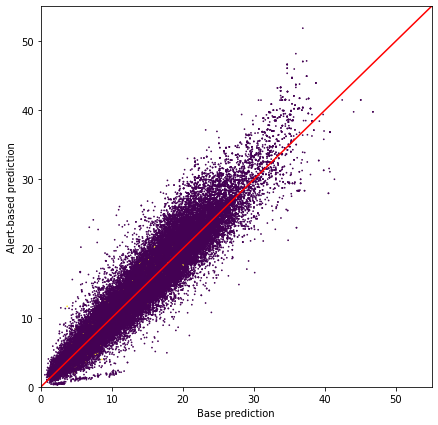

In [389]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(X_test_full.y_pred_base, X_test_full.y_pred_prio, s=0.5, c=X_test_full.alert_ind)
ax.set_xlabel("Base prediction")
ax.set_ylabel("Alert-based prediction")
ax.set_xlim(0, 55)
ax.set_ylim(0, 55)
ax.plot([0, 55], [0, 55], c='r')

<AxesSubplot:xlabel='base_error', ylabel='Density'>

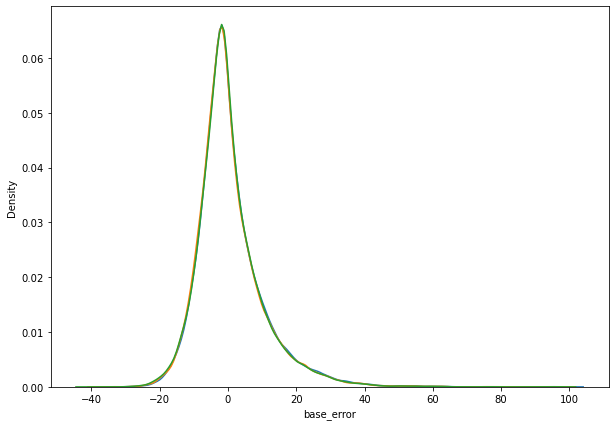

In [409]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 7))

sns.kdeplot(data=X_test_full, x="base_error")
sns.kdeplot(data=X_test_full, x="bool_error")
sns.kdeplot(data=X_test_full, x="prio_error")

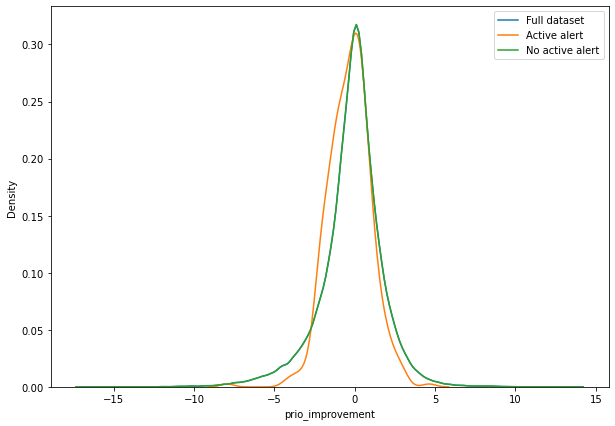

In [420]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.kdeplot(data=X_test_full, x="prio_improvement", label = "Full dataset")
sns.kdeplot(data=X_test_full[X_test_full.alert_ind == 1], x="prio_improvement", label = "Active alert")
sns.kdeplot(data=X_test_full[X_test_full.alert_ind == 0], x="prio_improvement", label = "No active alert")
ax.legend()

In [426]:
(
    X_test_full[X_test_full.alert_ind == 1].prio_improvement.mean(),
    X_test_full[X_test_full.alert_ind == 0].prio_improvement.mean()
)

(-0.32867175340652466, -0.2022334486246109)

## When alerts are active, do we underpredict?

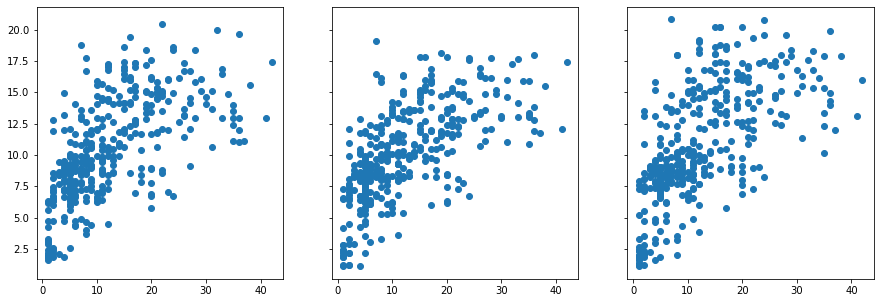

In [434]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

X_test_alert = X_test_full[X_test_full.alert_ind == 1]

axs[0].scatter(X_test_alert.y_test, X_test_alert.y_pred_base)
axs[1].scatter(X_test_alert.y_test, X_test_alert.y_pred_bool)
axs[2].scatter(X_test_alert.y_test, X_test_alert.y_pred_prio)
axs.

**Yes, and neither of the inclusions of alert data seems to improve this fact**

## When alerts are active, do we underpredict more than in similar situations?

# Experiment: using lower and upper bounds



In [435]:
# log cosh quantile is a regularized quantile loss function
def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        return grad, hess
    return _log_cosh_quantile

In [468]:
alpha = 0.95

In [469]:
model = XGBRegressor(objective=log_cosh_quantile(alpha),
                       n_estimators=125,
                       max_depth=5,
                       n_jobs=6,
                       learning_rate=.05)

In [470]:
model.fit(X_train_base, y_train_base)

<ipython-input-435-ec4161e2d7d6>:7: RuntimeWarning: overflow encountered in cosh
  hess = 1 / np.cosh(err)**2
<ipython-input-435-ec4161e2d7d6>:7: RuntimeWarning: overflow encountered in square
  hess = 1 / np.cosh(err)**2


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=125, n_jobs=6,
             num_parallel_tree=1,
             objective=<function log_cosh_quantile.<locals>._log_cosh_quantile at 0x15490f8b0>,
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [471]:
y_upper_smooth = model.predict(X_test_base)

In [472]:
model = XGBRegressor(objective=log_cosh_quantile(1-alpha),
                       n_estimators=125,
                       max_depth=5,
                       n_jobs=6,
                       learning_rate=.05)

In [473]:
model.fit(X_test_base, y_test_base)
y_lower_smooth = model.predict(X_test_base)

In [474]:
X_test_base_lu = X_test_base.copy()

In [475]:
X_test_base_lu['lower'] = y_lower_smooth
X_test_base_lu['upper'] = y_upper_smooth
X_test_base_lu['y_test'] = y_test_base

In [476]:
def is_within_bounds(row):
    lower = row.lower
    upper = row.upper
    y_test = row.y_test
    if lower <= y_test <= upper:
        return True
    else:
        return False

In [478]:
X_test_base_lu['correct'] = X_test_base_lu.apply(is_within_bounds, axis=1)

In [479]:
X_test_base_lu.correct.sum() / X_test_base_lu.correct.count()

0.3779542192807657

In [486]:
X_test_base

,direction,next_stop,lat,lon,hour,day,dow
374489,1,125,40.650328,-73.894332,0,16,1
374490,1,98,40.613789,-73.981462,0,16,1
374494,1,106,40.632499,-73.918642,0,16,1
374496,1,95,40.616830,-73.978283,0,16,1
374497,0,20,40.619278,-73.976383,0,16,1
...,...,...,...,...,...,...,...
501596,0,118,40.657750,-73.878915,4,22,0
501598,1,62,40.653146,-73.889566,4,22,0
501599,0,119,40.658488,-73.877714,4,22,0
501602,1,88,40.634244,-73.949158,4,22,0


<AxesSubplot:>

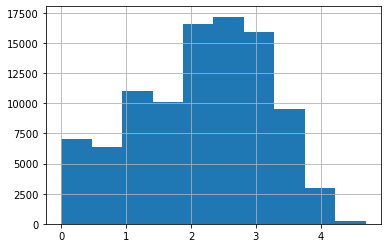

In [483]:
np.log(X_test_base_lu.y_test).hist()